In [1]:
from netCDF4 import Dataset
from pyproj import Proj,transform
from mpl_toolkits.basemap import Basemap
import datetime
import progressbar as bar

### Notes:
#### Spatial Reference System 

***Problem:*** These data are likely in the HRAP grid (http://www.emc.ncep.noaa.gov/mmb/ylin/pcpanl/stage4/), which is hard to deal with. Basemap assumes data are WGS84 prior to projecting.

***Solution:*** Convert the included lat/lon arrays to WGS84, then define a Basemap projection and project the data to it. This is only really necessary to view the climatology in a geographically meaningful way. Found the proj4 strings for the HRAP grid here (http://polyploid.net/blog/?p=216), very similar to dealing with the WRF grids...

#### Units

***Problem*** Data are in kg/km2, need to be converted to mm/grid cell.
- get grid cell size - grid cel size is variable....
- convert kg/km2 to mm/km2 - multiply by 1x10$^{-6}$

#### Time

***Problem:*** Time is in hours since a certain day.

***Solution:*** Convert to a datetime list using the certain date as an offset.

In [2]:
p1 = Proj('+proj=longlat +a=6371200 +b=6371200 +no_defs') # geographic projection for HRAP grid
p2 = Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs') # WGS84 geographic projection

In [3]:
fl = './stage4_map_daily_20041220-20150107.nc'
ds = Dataset(fl,'r')

In [4]:
lats = np.array(ds.variables['lat'])
lons = np.array(ds.variables['lon'])

In [5]:
lons,lats = transform(p1,p2,lons,lats) # reproject the HRAP grid to WGS84

In [6]:
m,n = lons.shape

In [7]:
# setup the basemap for displaying the results of the calculations
M = Basemap(resolution='i',llcrnrlon = lons.min()+15, llcrnrlat = lats.min()+2, urcrnrlon = lons.max(),
            urcrnrlat = lats.max()-10, projection='aea',lat_1=29.5,lat_2=45.5,
            lon_0=-96,lat_0=23)

x,y = M(lons,lats)

In [8]:
time = ds.variables['time']
print('Time Units: %s'%time.units)
timeoffset = time.units[-20:] # trip the string
strt = pd.to_datetime(timeoffset) # convert string into datetime object
time = np.array(ds.variables['time'])

def compute_time(time,offset):
    dt = datetime.timedelta(hours=time)
    time = offset+dt
    return str(time.date())

times = np.vectorize(compute_time)(time,strt)

Time Units: Hour since 2001-12-31T23:00:00Z


### Process Precip Climatology and Continuity 2005-2014

In [ ]:
# Iterate through the precip grids and compute the average
k,n,m = ds.variables['Total_precipitation_surface_1_Hour_Accumulation'].shape

clim = np.zeros((n,m))
clim[:] = np.NaN

cont = np.zeros_like(clim)

strt = 12 # 12
nd = 3661 # 3661
print('start: index = %s, date = %s'%(strt,times[strt]))
print('end: index = %s, date = %s'%(nd,times[nd]))
index = np.arange(strt,nd+1)
ct = 0

pb = bar.ProgressBar(min_value=0,max_value=nd-strt+1)
sums = []

#for r in range(n):
#    for c in range(m):
#        out[r,c] = np.nanmean(np.array(ds.variables['Total_precipitation_surface_1_Hour_Accumulation'][strt:nd,r,c]))
#        ct += 1
#        pb.update(ct)
        

for idx in index: # sum the 
    tmp = np.array(ds.variables['Total_precipitation_surface_1_Hour_Accumulation'][idx,:,:])
    clim = np.nansum([clim,tmp], axis= 0)
    cont = np.nansum([cont,np.isnan(tmp)], axis=0)
    
    sums.append(np.nansum(np.array(ds.variables['Total_precipitation_surface_1_Hour_Accumulation'][idx,:,:])))
    ct += 1
    pb.update(ct)
    
clim = clim/ct # compute mean daily precip

np.save('./data/nexrad_iv_p_clim_2004_2014.npy',clim)
np.save('./data/nexrad_iv_cont_2004-2014.npy',cont)

## Load the Processed Data

In [88]:
clim = np.load('./data/nexrad_iv_p_clim_2004_2014.npy')
cont = np.load('./data/nexrad_iv_cont_2004-2014.npy')

(0, 10)

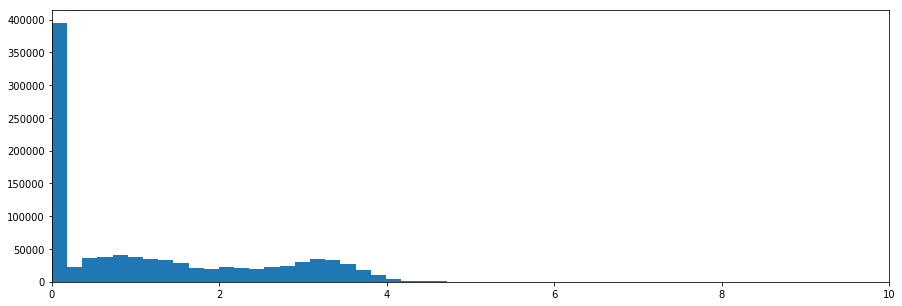

In [78]:
plt.figure(figsize=(15,5))
plt.hist(clim[np.isnan(clim)==0],1500);
plt.xlim(0,10)

In [14]:
clim = np.ma.masked_array(clim,(clim<=1) & (clim>=5))

In [76]:
ticks = np.arange(1,5.5,0.5)
labels = ['{:.1f}'.format(x) for x in list(ticks)]
labels[-1] = '>5.0'

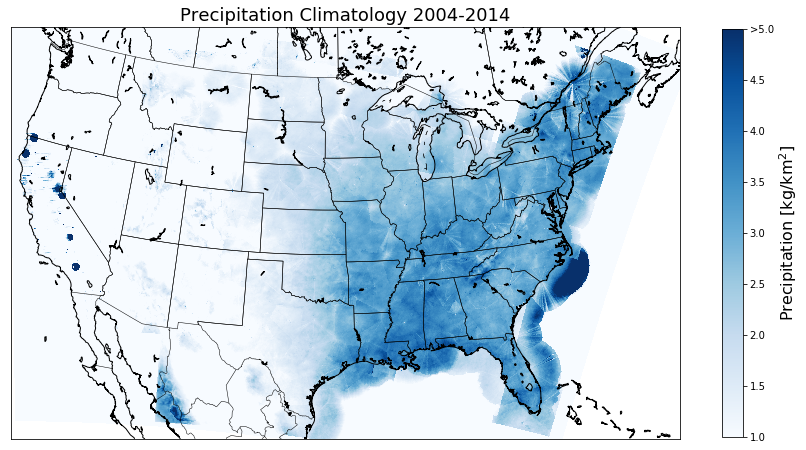

In [71]:
plt.figure(figsize=(15,10))
M.pcolormesh(x,y,clim,vmin=1,vmax=5,cmap='Blues')
M.drawstates()
M.drawcoastlines()
M.drawcountries()
cb = plt.colorbar(shrink=0.75)
cb.set_label('Precipitation [kg/km$^2$]', fontsize=16)
plt.title('Precipitation Climatology 2004-2014', fontsize=18)
cb.set_ticks(ticks)
cb.set_ticklabels(labels)

In [72]:
cont_per = cont/cont.max()

In [73]:
cont_ma = np.ma.masked_array(cont,cont==cont.max())

(0, 10)

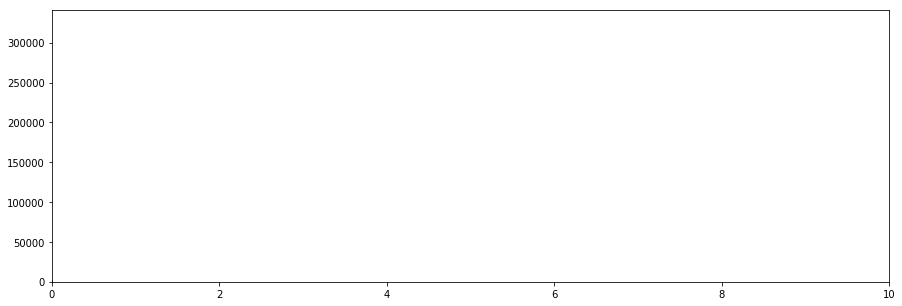

In [74]:
tmp = np.reshape(cont_per,(m*n))
plt.figure(figsize=(15,5))
plt.hist(tmp,1500);
plt.xlim(0,10)

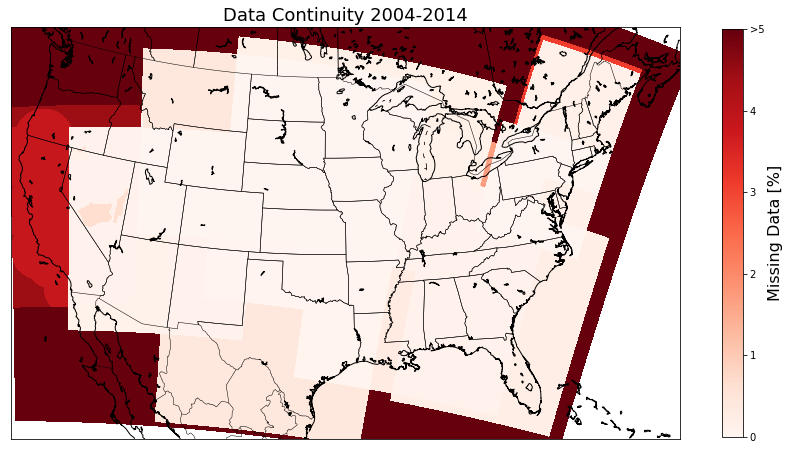

In [42]:
plt.figure(figsize=(15,10))
M.pcolormesh(x,y,cont_per,vmin=0,vmax=5,cmap='Reds')
M.drawstates()
M.drawcoastlines()
M.drawcountries()
cb = plt.colorbar(shrink=0.75)
plt.title('Data Continuity 2004-2014', fontsize=18)
cb.set_label('Missing Data [%]',fontsize=16)
cb.set_ticks(np.arange(0,6))
cb.set_ticklabels(['0','1','2','3','4','>5'])
plt.savefig('./figures/nexrad_iv_contiuity.png', dpi=300, bbox_inches='tight')